[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ee-ortiz/ISIS-4825_202510_IMAGENES_Y_VISION/blob/main/Laboratorio_06/Taller/MISIS4825_Laboratorio06_Taller.ipynb)

![image](https://drive.google.com/u/0/uc?id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d&export=download)

# Laboratorio 06 - Taller: Fundamentos de Machine Learning y Redes Neuronales

## Introducción

En este taller exploraremos el uso de TensorFlow y Keras para el diseño y entrenamiento de redes neuronales perceptrón multicapa. Utilizaremos el conjunto de datos **Alien vs. Predator** para construir un modelo capaz de clasificar imágenes de acuerdo a su clase.

## Contenido del Taller

1. **Preprocesamiento de Datos**  
   - Implemente técnicas de preprocesamiento como normalización, estandarización y aumentación de datos utilizando TensorFlow y Keras.  
   - Adicionalmente, puede aplicar cualquier procesamiento explicado previamente en el curso.  
   - Justifique cada técnica de preprocesamiento seleccionada y analice su impacto en el desempeño del modelo.

2. **Construcción de un Modelo de Red Neuronal Perceptrón Multicapa**  
   - Desarrolle un modelo de red neuronal perceptrón multicapa utilizando Keras.  
   - Discuta la elección de la arquitectura, detallando el número de capas, la cantidad de neuronas por capa y las funciones de activación empleadas.

3. **Definición de Funciones de Callbacks para Monitorear el Entrenamiento**  
   - Implemente callbacks en TensorFlow y Keras para monitorear el proceso de entrenamiento.  
   - Explique cómo estos callbacks pueden ayudar a identificar problemas como el sobreajuste o un entrenamiento insuficiente.  
   - Justifique la selección y configuración de cada callback.

4. **Entrenamiento y Exploración de Resultados**  
   - Detalle el proceso de entrenamiento, incluyendo la elección de la tasa de aprendizaje, el optimizador y la función de pérdida.  
   - Analice los resultados obtenidos utilizando métricas de desempeño como precisión, recall y F1-score.  
   - Compare los resultados y discuta posibles mejoras en el modelo.

## Datos

[Alien vs. Predator images](https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images)

# **Taller 6**

### **Descarga y Preparación del dataset**

In [16]:
import json
import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split

In [11]:
with open('./kaggle.json') as f:
    kaggle_credentials = json.load(f)

os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('pmigdal/alien-vs-predator-images', unzip=True)

redundant_folder_path = 'alien_vs_predator_thumbnails'
if os.path.exists(redundant_folder_path):
    shutil.rmtree(redundant_folder_path)

Dataset URL: https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images


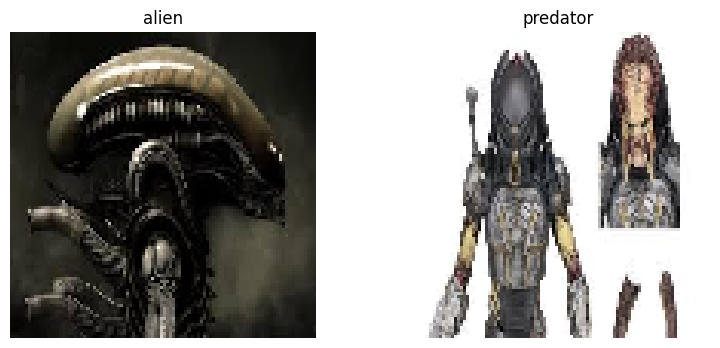

In [12]:
data_dir = 'data/train'
data_categories = os.listdir(data_dir)

plt.figure(figsize=(12, 10))
for i, category in enumerate(data_categories):
    folder = os.path.join(data_dir, category)
    image_file = os.listdir(folder)[13]
    img_path = os.path.join(folder, image_file)
    img = keras.preprocessing.image.load_img(img_path, target_size=(100, 100))
    img_array = keras.preprocessing.image.img_to_array(img) / 255.0
    plt.subplot(3, 3, i + 1)
    plt.imshow(img_array)
    plt.title(category)
    plt.axis('off')
plt.tight_layout()
plt.show()

### **Preparación de Datos y División en Entrenamiento, Validación y Test**

In [13]:
filepaths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir)
             for f in filenames if os.path.splitext(f)[1].lower() in ['.png','.jpg','.jpeg']]
labels = [os.path.split(os.path.split(path)[0])[1] for path in filepaths]

data_df = pd.DataFrame({'filepath': filepaths, 'label': labels})

train_df, test_val_df = train_test_split(data_df, test_size=0.3, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=2/3, random_state=42)

print("Total de imágenes:", len(data_df))
print("Entrenamiento:", len(train_df))
print("Validación:", len(val_df))
print("Test:", len(test_df))

Total de imágenes: 694
Entrenamiento: 485
Validación: 140
Test: 69


#### **Procesamiento de Datos**  
   

##### Justificación

Parametros para ImageDataGenerator:

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [14]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
)

test_val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(100, 100),
    batch_size=32,
)

val_gen = test_val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=(100, 100),
    batch_size=32,
    shuffle=False,
)

test_gen = test_val_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=(100, 100),
    batch_size=32,
    shuffle=False,
)

Found 485 validated image filenames belonging to 2 classes.
Found 140 validated image filenames belonging to 2 classes.
Found 69 validated image filenames belonging to 2 classes.


### **Construcción y Compilación del Modelo**

##### Justificación

Falta ajustar las capas

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout

model = Sequential([
    Flatten(input_shape=(100, 100, 3)),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(len(data_categories), activation='softmax')
])

model.summary()

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

/home/pukini/.pyenv/versions/3.12.9/envs/iv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    15,360,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,492,354 (59.10 MB)

 Trainable params: 15,492,354 (59.10 MB)

 Non-trainable params: 0 (0.00 B)

### **Entrenamiento del Modelo**

##### Justificación

Falta ajustar los callbacks

In [17]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True,
                                   monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

callbacks = [model_checkpoint, early_stopping, reduce_lr]

with tf.device('/device:GPU:0'):
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        callbacks=callbacks
    )

Epoch 1/50


/home/pukini/.pyenv/versions/3.12.9/envs/iv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5757 - loss: 10.4304

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.5769 - loss: 10.2337 - val_accuracy: 0.6143 - val_loss: 0.8614 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.5544 - loss: 2.4241 - val_accuracy: 0.5929 - val_loss: 0.9395 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.6240 - loss: 2.0683 - val_accuracy: 0.4643 - val_loss: 4.0860 - learning_rate: 0.0010
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.5530 - loss: 2.3238 - val_accuracy: 0.5429 - val_loss: 1.5656 - learning_rate: 0.0010
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5984 - loss: 0.9612 - val_accuracy: 0.5643 - val_loss: 1.0743 - learning_rate: 0.0010
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.5658 - loss: 0.8407

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.5678 - loss: 0.8372 - val_accuracy: 0.5786 - val_loss: 0.6898 - learning_rate: 0.0010
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.6172 - loss: 0.7901 - val_accuracy: 0.5643 - val_loss: 1.0181 - learning_rate: 0.0010
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6248 - loss: 0.7643

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 0.6241 - loss: 0.7643 - val_accuracy: 0.6000 - val_loss: 0.6876 - learning_rate: 0.0010
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.6104 - loss: 0.7351 - val_accuracy: 0.6071 - val_loss: 0.7076 - learning_rate: 0.0010
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.6297 - loss: 0.7303 - val_accuracy: 0.5357 - val_loss: 0.7903 - learning_rate: 0.0010
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.6218 - loss: 0.7133 - val_accuracy: 0.6214 - val_loss: 0.7207 - learning_rate: 0.0010
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.6298 - loss: 0.7697 - val_accuracy: 0.6071 - val_loss: 0.7851 - learning_rate: 0.0010
Epoch 13/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6310 - loss: 0.7394
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.6298 - loss: 0.7421 - val_ac

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.6236 - loss: 0.6346 - val_accuracy: 0.6714 - val_loss: 0.6714 - learning_rate: 1.0000e-04
Epoch 16/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.7022 - loss: 0.5745 - val_accuracy: 0.6643 - val_loss: 0.6890 - learning_rate: 1.0000e-04
Epoch 17/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6303 - loss: 0.6592

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.6316 - loss: 0.6573 - val_accuracy: 0.6929 - val_loss: 0.6439 - learning_rate: 1.0000e-04
Epoch 18/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.6573 - loss: 0.5951 - val_accuracy: 0.6643 - val_loss: 0.6621 - learning_rate: 1.0000e-04
Epoch 19/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6899 - loss: 0.6036

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.6892 - loss: 0.6045 - val_accuracy: 0.6857 - val_loss: 0.6366 - learning_rate: 1.0000e-04
Epoch 20/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.6649 - loss: 0.6187 - val_accuracy: 0.6714 - val_loss: 0.6399 - learning_rate: 1.0000e-04
Epoch 21/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.6714 - loss: 0.5668 - val_accuracy: 0.6357 - val_loss: 0.6397 - learning_rate: 1.0000e-04
Epoch 22/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.6796 - loss: 0.5791 - val_accuracy: 0.6500 - val_loss: 0.6439 - learning_rate: 1.0000e-04
Epoch 23/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.7070 - loss: 0.5660 - val_accuracy: 0.6571 - val_loss: 0.6549 - learning_rate: 1.0000e-04
Epoch 24/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6722 - loss: 0.6033
Epoch 24: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.6733 - 

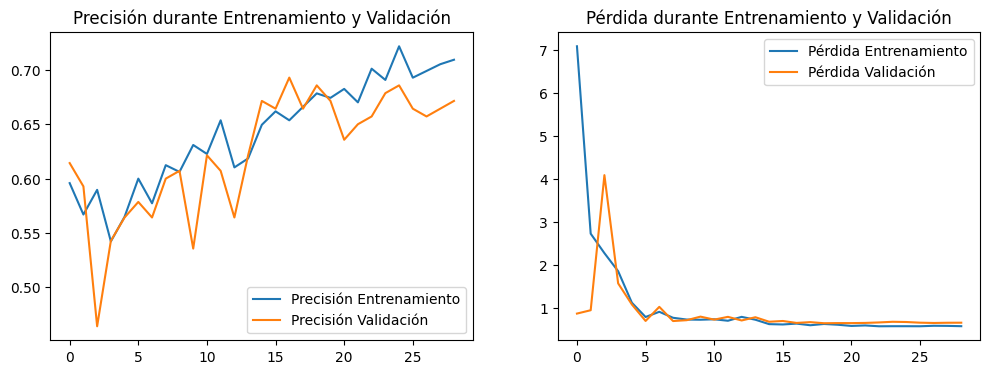

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7e9381f92e80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


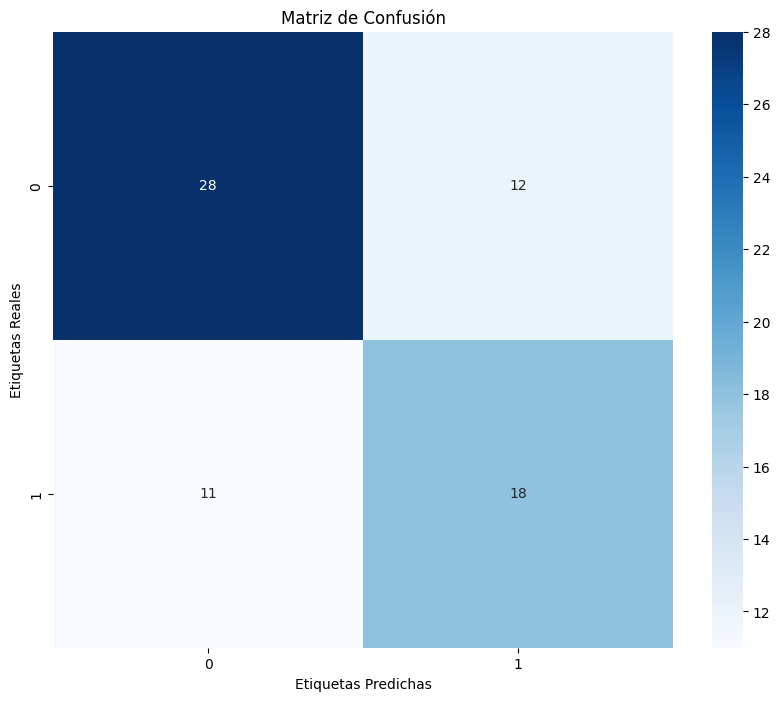

              precision    recall  f1-score   support

       alien       0.72      0.70      0.71        40
    predator       0.60      0.62      0.61        29

    accuracy                           0.67        69
   macro avg       0.66      0.66      0.66        69
weighted avg       0.67      0.67      0.67        69



In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión Entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión Validación')
plt.legend(loc='lower right')
plt.title('Precisión durante Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida Entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida Validación')
plt.legend(loc='upper right')
plt.title('Pérdida durante Entrenamiento y Validación')
plt.show()

from keras.models import load_model


best_model = load_model('best_model.h5')

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_gen.reset()
predictions = best_model.predict(test_gen, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_test = test_gen.classes

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.ylabel('Etiquetas Reales')
plt.xlabel('Etiquetas Predichas')
plt.show()

print(classification_report(y_test, y_pred, target_names=data_categories))
